Notebook for how to load the segmentation data from the NORD-FKB project.

In [9]:
import os
import json
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import cv2 as cv
import numpy as np

In [10]:
data_dir = "20250507_NORD_FKB_Som_Korrigert"
ann_file = os.path.join(data_dir, "coco_dataset.json")

coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [22]:
def display_image_with_mask(coco, img_id):
    # Load image
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(data_dir, img_info['file_name'])
    image = cv.imread(img_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(ann_ids)

    # Initialize a color mask
    color_mask = np.zeros_like(image)

    # Iterate over each annotation to load and overlay the mask
    for ann_id, ann in enumerate(anns):
        category_name = coco.loadCats(ann['category_id'])[0]['name']
        mask_filename = f"{img_info['file_name'].replace('.tif', '')}-{ann_id}-{category_name}.tif".replace("Image_rgb/", "")
        mask_path = os.path.join("20250507_NORD_FKB_Som_Korrigert/Mask", mask_filename)
        
        # Load mask
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        if mask is not None:
            color_mask[mask > 0] = [255, 0, 0]  # Red color for mask

    # Overlay mask on image
    overlayed_image = cv.addWeighted(image, 0.7, color_mask, 0.3, 0)

    # Display image with mask
    plt.imshow(overlayed_image)
    plt.axis('off')
    plt.show()

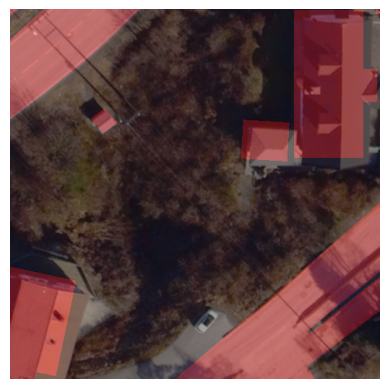

In [23]:
# Get a random image id
img_ids = coco.getImgIds()
img_id = img_ids[np.random.randint(0, len(img_ids))]

# Display the image with annotations
display_image_with_mask(coco, img_id)

In [26]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [40]:
def unnormalize_image(tensor, mean, std):
    """
    Un-normalize a tensor image to its original form.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_image(image_tensor, mask_tensor=None):
    """
    Visualize a single image tensor with an optional mask overlay.
    """
    # Un-normalize the image
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = unnormalize_image(image_tensor.clone(), mean, std)
    
    # Convert to numpy and transpose to (H, W, C)
    image = image.permute(1, 2, 0).cpu().numpy()
    
    # Clip values to [0, 1] range for display
    image = np.clip(image, 0, 1)
    
    plt.imshow(image)
    
    if mask_tensor is not None:
        # Convert mask to numpy
        mask = mask_tensor.cpu().numpy()
        
        # Create a color mask
        color_mask = np.zeros_like(image)
        color_mask[mask > 0] = [1, 0, 0]  # Red color for mask
        
        # Overlay mask on image
        plt.imshow(color_mask, alpha=0.5)  # Adjust alpha for transparency

    plt.axis('off')
    plt.show()

In [41]:
class COCOSegmentationDataset(Dataset):
    def __init__(self, data_dir, ann_file, transform=None):
        self.data_dir = data_dir
        self.coco = COCO(ann_file)
        self.img_ids = self.coco.getImgIds()
        self.transform = transform
        self.mask_dir = os.path.join(data_dir, 'Mask')

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.data_dir, img_info['file_name'])
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Initialize a color mask
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        # Iterate over each annotation to load and overlay the mask
        for ann_idx, ann in enumerate(anns):
            category_name = self.coco.loadCats(ann['category_id'])[0]['name']
            mask_filename = f"{img_info['file_name'].replace('.tif', '')}-{ann_idx}-{category_name}.tif".replace("Image_rgb/", "")
            mask_path = os.path.join(self.mask_dir, mask_filename)
            
            # Load mask
            ann_mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
            if ann_mask is not None:
                mask[ann_mask > 0] = ann['category_id']

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            mask = torch.from_numpy(mask).long()

        return image, mask

# Define transformations
# These are standard transformations for images (coming from imagenet)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and dataloader
data_dir = '20250507_NORD_FKB_Som_Korrigert'
ann_file = os.path.join(data_dir, 'coco_dataset.json')
dataset = COCOSegmentationDataset(data_dir, ann_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


torch.Size([3, 512, 512]) tensor(-1.9832) tensor(1.8731)
torch.Size([512, 512]) tensor(0) tensor(246)


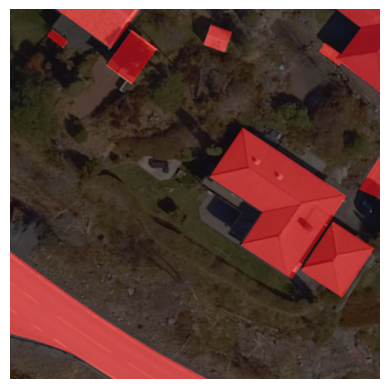

torch.Size([3, 512, 512]) tensor(-1.9809) tensor(2.2566)
torch.Size([512, 512]) tensor(0) tensor(246)


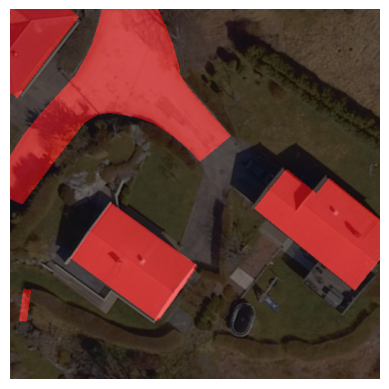

torch.Size([3, 512, 512]) tensor(-1.8957) tensor(2.0648)
torch.Size([512, 512]) tensor(0) tensor(231)


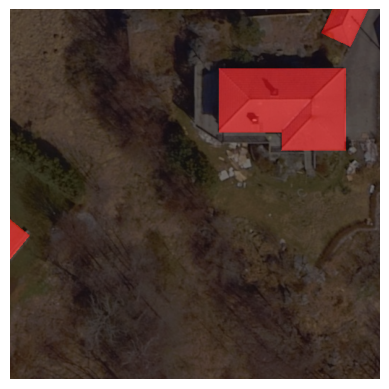

torch.Size([3, 512, 512]) tensor(-1.9657) tensor(2.0997)
torch.Size([512, 512]) tensor(0) tensor(236)


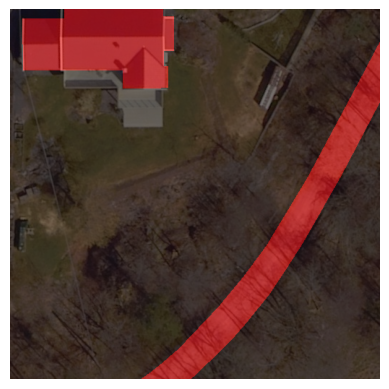

torch.Size([3, 512, 512]) tensor(-1.7522) tensor(1.5639)
torch.Size([512, 512]) tensor(0) tensor(250)


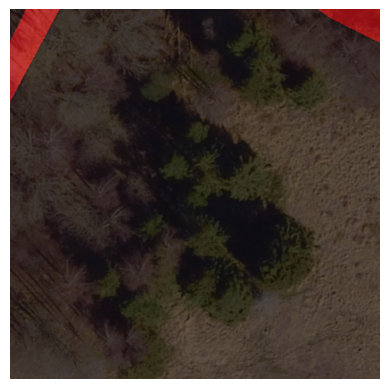

In [42]:
for i in range(5):
    image, mask = dataset[i]
    print(image.shape, image.min(), image.max())
    print(mask.shape, mask.min(), mask.max())
    visualize_image(image, mask)